In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib
import warnings
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [2]:
df_ad = pd.read_csv('cleaned_ads_data.csv') # read clean ad data
df_nonad = pd.read_csv('cleaned_nonads_data.csv') # read clean nonad data
df_ad['y'] = df_ad['y'].map({1:'да', 0:'нет'}) # replace all 1 and 0 to да и нет
df_nonad['y'] = df_nonad['y'].map({1:'да', 0:'нет'}) # replace all 1 and 0 to да и нет


In [3]:
frequent_ad = pd.Series(' '.join(df_ad.value).split()).value_counts()[:30] #get top 30 frequent valuess 
frequent_nonad = pd.Series(' '.join(df_nonad.value).split()).value_counts()[:30] #get top 30 frequent values

<Figure size 1080x720 with 0 Axes>

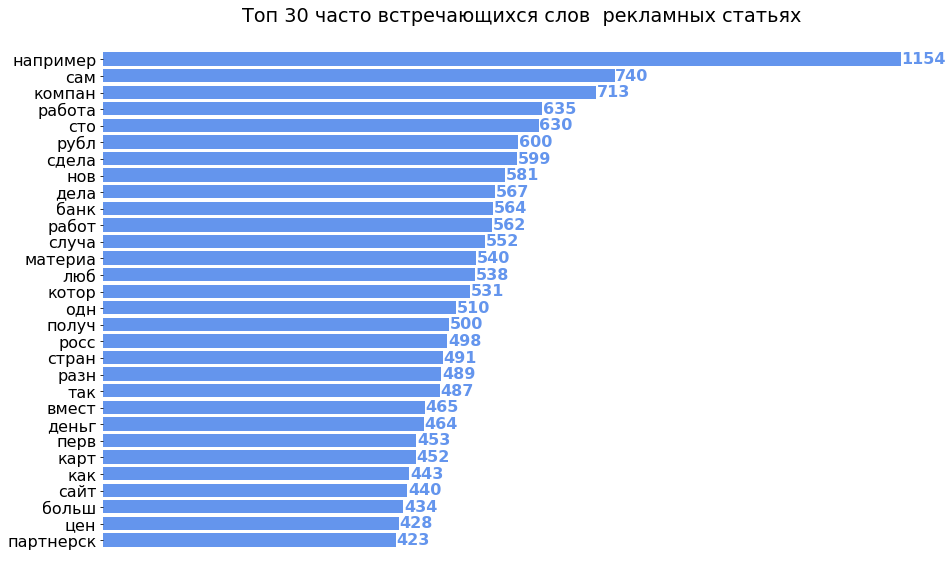

In [5]:
plt.figure(figsize=(15,10)) # plot figure
fig, ax = plt.subplots(figsize=(15, 10)) # plot subplots
width = 0.05 # width of 
ind = np.arange(len(frequent_ad))
ax.barh(frequent_ad.index.values, frequent_ad.values, color = '#6495ED', align = 'center') # draw barh
for i, v in enumerate(frequent_ad.values): # change position of values on barhs
    ax.text(v + 1, i + 0.27, str(v), fontweight='bold', color='#6495ED')
for spine in plt.gca().spines.values(): #get rid of frame
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False) #get rid of x ticks
ax.invert_yaxis() # to make descending list instead of ascending
plt.title("Топ 30 часто встречающихся слов  рекламных статьях") # set title to Топ 30 часто встречающихся слов  рекламных статьях
matplotlib.rcParams.update({'font.size': 16}) # make font size equals to 16

<Figure size 1080x720 with 0 Axes>

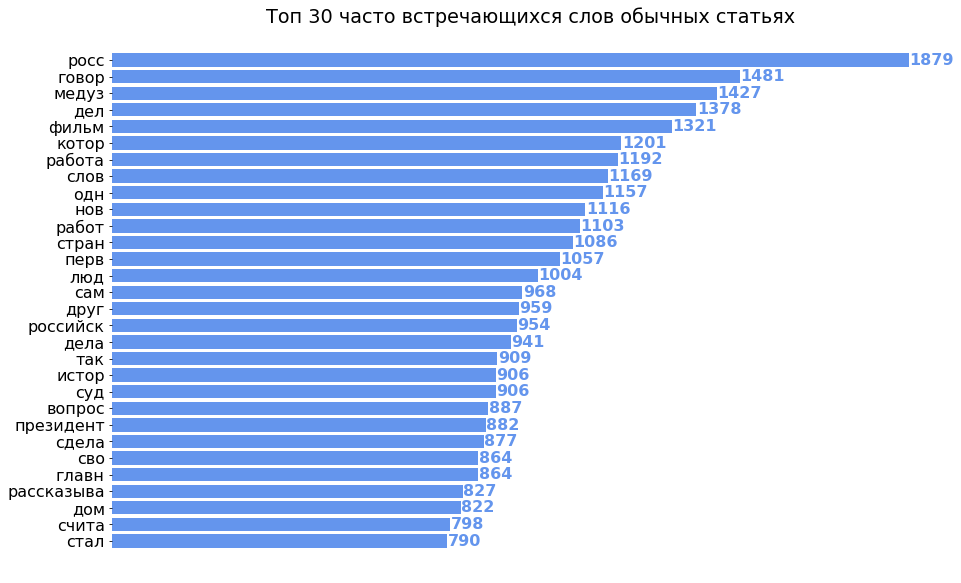

In [13]:
plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(15, 10))
width = 0.05
ind = np.arange(len(frequent_nonad))
ax.barh(frequent_nonad.index.values, frequent_nonad.values, color = '#6495ED', align = 'center') # plot barh
#ax.set_yticks(ind + width / 2)
#ax.set_yticklabels(frequent_nonad.index.values, minor = False)
for i, v in enumerate(frequent_nonad.values): # change position of values that are on barh
    ax.text(v + 1, i + 0.27, str(v), fontweight='bold', color='#6495ED')
for spine in plt.gca().spines.values(): # get rid of frame
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False) # get rid of x ticks
ax.invert_yaxis() # to make descending list instead of ascending
plt.title("Топ 30 часто встречающихся слов обычных статьях") # plot title
matplotlib.rcParams.update({'font.size': 16}) # make font size equals to 16

As we can see above word материа и партнерск will give us overfitting to meduza's posts, we need to get rid of it
On meduza we can find a lot of political articles we need to get rid of word that can overfit to that articles
So we get rid of some political_words

In [24]:
warnings.filterwarnings("ignore", category=DeprecationWarning) #ignore warning
overfit_ad = ['материа', 'медуз', 'партнерск'] # list of political_words
overfit_nonad = ['росс', 'медуз', 'президент', 'российск'] #list of political words
for i in range(len(df_ad)):
    df_ad.ix[i].value = [item for item in df_ad.iloc[i].value.split() if item not in overfit_ad] # get rid of political words
    df_ad.ix[i].value = [' '.join(item for item in df_ad.iloc[i].value)] # convert list to str
for i in range(len(df_nonad)):
    df_nonad.ix[i].value = [item for item in df_nonad.iloc[i].value.split() if item not in overfit_nonad] # get rid of political words
    df_nonad.ix[i].value = [' '.join(item for item in df_nonad.iloc[i].value)] # convert list to str
df_ad['value'] = [' '.join(item) for item in df_ad['value']] #convert list to str
df_nonad['value'] = [' '.join(item) for item in df_nonad['value']]# convert list to str

In [25]:
df = pd.concat([df_ad, df_nonad]) # join ad clean dataframe and nonad clean dataframe to 1 dataframe
df.reset_index(drop=True, inplace=True) # reindex dataframe
df = df.sample(frac=1).reset_index(drop=True) #shuffle df

In [26]:
df['count_word'] = df["value"].apply(lambda x: len(str(x).split())) #Word count in each article
df['count_unique_word'] = df["value"].apply(lambda x: len(set(str(x).split()))) #Unique word count
df['count_letters']=df["value"].apply(lambda x: len(str(x))) #Letter count
df['mean_word_len'] = df["value"].apply(lambda x: np.mean([len(w) for w in str(x).split()])) #Average length of the words
df['unique_percent'] = df['count_unique_word'] * 100 / df['count_word'] # Word count percent in each article

Text(0.5,1,'Количесто слов в каждой статье')

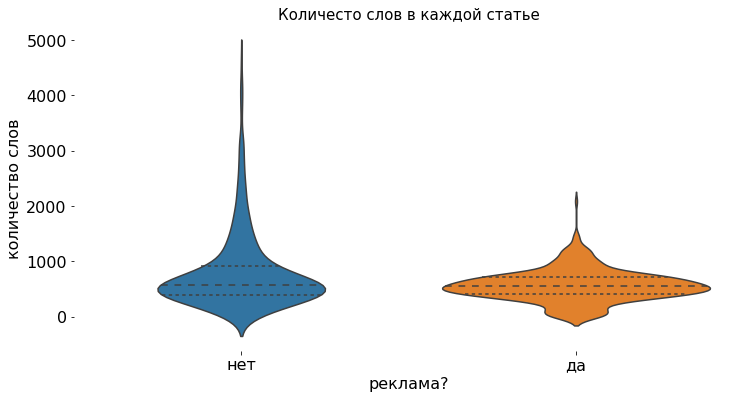

In [27]:
plt.figure(figsize=(12,6)) # plot figure
plt.subplot() # plot subplot
sns.violinplot(y='count_word', x = 'y', data = df, inner='quart') # plot violinplot
plt.xlabel('реклама?', fontsize=16) # set xlabel to реклама?
plt.ylabel('количество слов', fontsize=16) # set ylabel to количество слов
for spine in plt.gca().spines.values(): # get rid of frame
    spine.set_visible(False)
plt.title("Количесто слов в каждой статье", fontsize=15) #Количество слов в каждой статье

As we can see above that ad articles have a count_word around 500

In [28]:
temp_df = pd.melt(df,value_vars=['count_word', 'count_unique_word'], id_vars='y') # join columns
temp_df['реклама?'] = temp_df['y'] # to plot реклама? instead of y in next plot

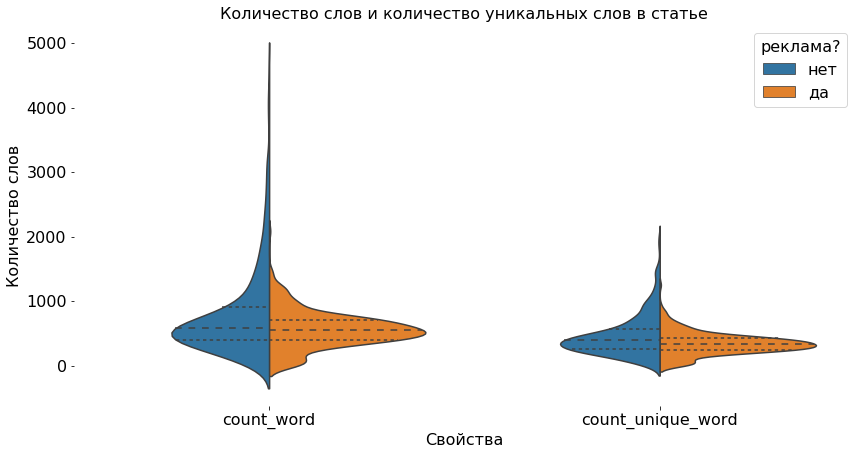

In [29]:
plt.figure(figsize=(14,7)) # plot figure
sns.violinplot(x='variable', y='value', hue='реклама?', data=temp_df,split=True,inner='quartile') # plot violinplot
plt.title("Количество слов и количество уникальных слов в статье", fontsize=16)#set xlabel to оличество слов и количество уникальных слов в статье
plt.xlabel("Свойства", fontsize=16) # set xlabel to Свойства
plt.ylabel("Количество слов", fontsize=16) # set ylabel to Количество слов
for spine in plt.gca().spines.values(): # get rid of frame
    spine.set_visible(False)

Text(0.5,1,'Процент уникальных слов из всех слов в статьях')

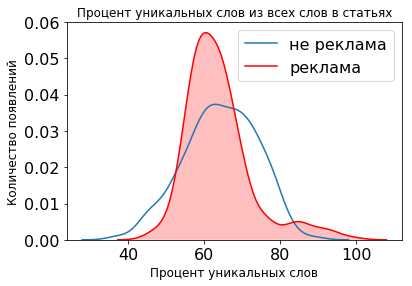

In [30]:
ax = sns.kdeplot(df[df['y'] == "нет"]['unique_percent'], label = 'не реклама') #plot unique percent as не реклама
ax = sns.kdeplot(df[df['y'] == "да"].unique_percent, label = "реклама", shade=True, color='r') # plot unique percent as реклама
plt.ylabel('Количество появлений',fontsize=12) # set ylabel Количество появлений
plt.xlabel('Процент уникальных слов', fontsize=12) # set xlabel Процент уникальных слов
plt.title('Процент уникальных слов из всех слов в статьях', fontsize=12) #set title Процент уникальных слов из всех слов в статьях

In [31]:
df['y'] = df['y'].map({'да':1, 'нет': 0})#set values to 1 and 0 instead of да and нет

In [32]:
df['bigram'] = 2 # create column bigram
df = df.copy() # to get rid of Copy Warning
for i in range(len(df.bigram)): # fill bigram column with top 10 frequent bigram
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(word_tokenize(df.iloc[i].value))
    df.loc[i, 'bigram'] = [finder.nbest(bigram_measures.pmi, 10)]

In [33]:
df['trigram'] = 3 # create column trigram
df = df.copy() # to get rid of copy warning
for i in range(len(df.trigram)): # fill trigram column with top 3 frequent trigram
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = TrigramCollocationFinder.from_words(word_tokenize(df.iloc[i].value))
    df.loc[i, 'trigram'] = [finder.nbest(trigram_measures.pmi, 3)]

In [34]:
y = df['y'] # get y value
x = df.drop('y',axis=1) # get x value

In [35]:
vect = TfidfVectorizer(max_features=700) # get vectorizer
x_dtm = vect.fit_transform(x['value']) # fit and transform x values to vector
clf = LogisticRegression() # get classifier
x_train, x_test, y_train, y_test = train_test_split(x_dtm, y, random_state=42, test_size=0.3) # split to train and test
clf.fit(x_train.toarray(), y_train) #train clf
clf.score(x_test.toarray(), y_test) #test clf

0.9489795918367347

In [36]:
vect = TfidfVectorizer(max_features=700) # get vectorizerr
x_dtm = vect.fit_transform(x['value']) #fit and transform x values to vector
clf = GaussianNB() # get classifier
x_train, x_test, y_train, y_test = train_test_split(x_dtm, y, random_state=42, test_size=0.3) # split to train and test
clf.fit(x_train.toarray(), y_train) #train clf
clf.score(x_test.toarray(), y_test) #test clf

0.9625850340136054

In [37]:
df1 = df.drop(['count_word', 'count_unique_word', 'count_letters', 'mean_word_len', 'unique_percent'],axis=1) #get rid of useless values to save df
df1.to_csv('tested_data.csv', index=False) #save df to csv